<a href="https://colab.research.google.com/github/nyculescu/handson-ml2/blob/master/04_training_linear_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Chapter 4 – Training Linear Models**

_This notebook contains all the sample code and solutions to the exercises in chapter 4._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/04_training_linear_models.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Linear regression using the Normal Equation

To find the value of θ that minimizes the cost function, there is a closed-form solution—in other words, a mathematical equation that gives the result directly. This is called the Normal Equation:

$\hat{\theta} = {(X^TX)}^{-1} {X^T} {y}$, where:
* $\hat{\theta}$ is the value of θ that minimizes the cost function
* y is the vector of target values containing y(1) to y(m)

In [0]:
import numpy as np

X = 2 * np.random.rand(100, 1)
# The function that we used to generate the data is y = 4 + 3x1 + Gaussian noise
y = 4 + 3 * X + np.random.randn(100, 1)

Saving figure generated_data_plot


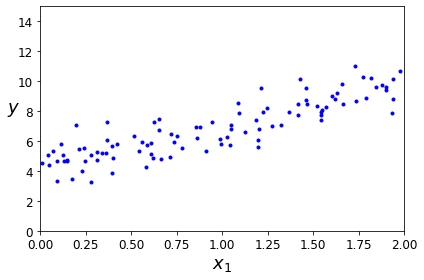

In [3]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot")
plt.show()

Now let’s compute $\hat{\theta}$ using the Normal Equation. 
* use the inv() function to compute the inverse of a matrix
* the dot() method for matrix multiplication

In [0]:
X_b = np.c_[np.ones((100, 1)), X]  # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [5]:
theta_best

array([[4.21509616],
       [2.77011339]])

We would have hoped for ${\theta}_0$ = 4 and ${\theta}_1$ = 3 instead of ${\theta}_0$ = 4.215 and ${\theta}_1$ = 2.770. Close enough, but the noise made it impossible to recover the exact parameters of the original function.

Now you can make predictions using $\hat{\theta}$:

In [6]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

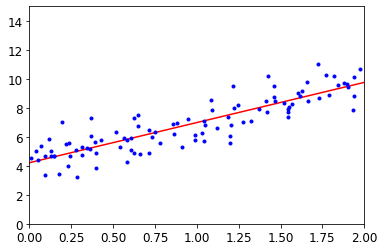

In [7]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

The figure in the book actually corresponds to the following code, with a legend and axis labels:

Saving figure linear_model_predictions_plot


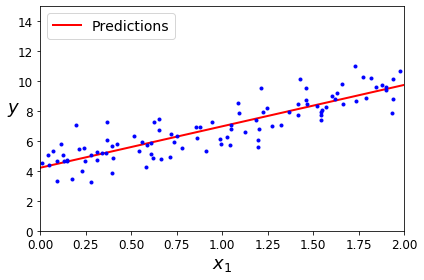

In [8]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
save_fig("linear_model_predictions_plot")
plt.show()

> Note that Scikit-Learn separates the bias term *intercept_* from the feature weights *coef_*

In [9]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [10]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

The `LinearRegression` class is based on the `scipy.linalg.lstsq()` function (the name stands for "least squares"), which you could call directly:

In [11]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

This function computes ${X}^+{y}$, where ${X}^{+}$ is the _pseudoinverse_ of ${X}$ (specifically the Moore-Penrose inverse). You can use `np.linalg.pinv()` to compute the pseudoinverse directly:

In [12]:
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

The pseudoinverse itself is computed using a standard matrix factorization technique called Singular Value Decomposition (SVD)

> **Why use this approach?**

1. The pseudoinverse is computed as ${X}^+ = {V} {E}^+ {U}^T$. This approach is more efficient than computing the Normal Equation, plus it handles edge cases nicely: indeed, the Normal Equation may not work if the matrix ${X}^T {X}$ is not invertible (i.e., singular), such as if m < n or if some features are redundant, but the pseudoinverse is always defined.

2. The Normal Equation computes the inverse of ${X}^T {X}$, which is an (n + 1) × (n + 1) matrix (where n is the number of features). The computational complexity of inverting such a matrix is typically about O(${n}^{2.4}$) to O(${n}^{3}$). The SVD approach used by Scikit-Learn’s LinearRegression class is about O(${n}^{2}$) -- If you double the number of features, you multiply the computation time by roughly 4, compared to 8 (Normal Eq)

> Now we will look at very **different ways to train a Linear Regression** model, better suited for cases where there are a **large number of features, or too many training instances to fit in memory**.

# Normal Equation vs Gradient Descent

> While the Normal Equation can only perform Linear Regression, the Gradient Descent algorithms can be used to train many other models

Comparison of algos for Linear Regression

| Algorithm       | Large m | Out-of-core support | Large n | Hyperparams | Scaling required | Scikit-Learn     |
|-----------------|---------|---------------------|---------|-------------|------------------|------------------|
| Normal Equation | Fast    | No                  | Slow    | 0           | No               | n/a              |
| SVD             | Fast    | No                  | Slow    | 0           | No               | LinearRegression |
| Batch GD        | Slow    | No                  | Fast    | 2           | Yes              | SGDRegressor     |
| Stochastic GD   | Fast    | Yes                 | Fast    | ≥2          | Yes              | SGDRegressor     |
| Mini-batch GD   | Fast    | Yes                 | Fast    | ≥2          | Yes              | SGDRegressor     |

> There is almost no difference after training: all these algorithms end up with very similar models and make predictions in exactly the same way.

# Gradient descent

Gradient Descent is a very generic optimization algorithm capable of finding optimal solutions to a wide range of problems. The general idea of Gradient Descent is to **tweak parameters iteratively in order to minimize a cost function**.

> Fortunately, the MSE cost function for a Linear Regression model happens to be a convex function

> When using Gradient Descent, you should ensure that all features have a similar scale (e.g., using Scikit-Learn’s StandardScaler class), or else it will take much longer to converge.

![](https://github.com/nyculescu/handson-ml2/blob/master/images/training_linear_models/gradient_descent_paths_in_parameter_space.jpg?raw=1)

Gradient Descent algorithms end up near the minimum, but Batch GD’s path actually stops at the minimum, while both Stochastic GD and Mini-batch GD continue to walk around.

> Batch GD takes a lot of time to take each step, and Stochastic GD and Mini-batch GD would also reach the minimum if you used a good learning schedule.

## 1) Linear regression using batch gradient descent

We need to calculate how much the cost function will change if you change ${\theta_j}$ just a little bit (partial derivative).

The gradient vector, noted ${\nabla}_{\theta}{MSE(\theta)}$, contains all the partial derivatives of the cost function (one for each model parameter).

$${\nabla}_{\theta}{MSE(\theta)} = \left(\begin{array}
{rrr}
{\frac{\partial}{\partial\theta_0}{MSE(\theta)}}\\
{\frac{\partial}{\partial\theta_1}{MSE(\theta)}}\\
{...}\\
{\frac{\partial}{\partial\theta_n}{MSE(\theta)}}
\end{array}\right)
= \frac{2}{m}{X^T}{X\theta-y}
$$

Batch Gradient Descent uses the whole batch of training data at every step.

> **Training a Linear Regression** model when there are **hundreds of thousands of features** is much **faster using Gradient Descent** than using the Normal Equation or SVD decomposition

Once you have the gradient vector, which points uphill, just go in the opposite direction to go downhill. This means subtracting ${\nabla}_{\theta}{MSE(\theta)}$ from θ. This is where the learning rate η comes into play: multiply the gradient vector by η to determine the size of the downhill step.

Gradient Descent step: ${\theta}^{nextstep} = {\theta-\eta}{\nabla_\theta}{MSE(\theta)}$

In [0]:
eta = 0.1  # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)  # random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [14]:
theta

array([[4.21509616],
       [2.77011339]])

In [15]:
X_new_b.dot(theta)

array([[4.21509616],
       [9.75532293]])

In [0]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

&darr; The first 10 steps of Gradient Descent using three different learning rates (the dashed line represents the starting point)

Saving figure gradient_descent_plot


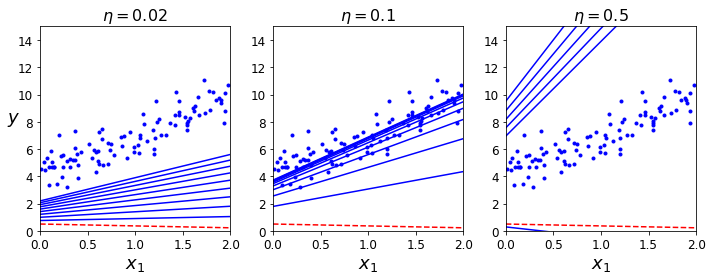

In [17]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

save_fig("gradient_descent_plot")
plt.show()

On the left, the learning rate is too low: the algorithm will eventually reach the solution, but it will take a long time. 

In the middle, the learning rate looks pretty good: in just a few iterations, it has already converged to the solution. 

On the right, the learning rate is too high: the algorithm diverges, jumping all over the place and actually getting further and further away from the solution at every step.

> To find a good *learning rate*, you can use *grid search*. 

> You may want to **limit the number of iterations** so that grid search can eliminate models that take too long to converge.
A simple solution is to set a very large number of iterations but to interrupt the algorithm when the gradient vector becomes tiny — that is, when its norm becomes smaller than a tiny number ϵ (called the *tolerance*) — because this happens when Gradient Descent has (almost) reached the minimum.

## 2) Stochastic Gradient Descent


The main problem with Batch Gradient Descent is the fact that it uses the whole training set to compute the gradients at every step.

At the opposite extreme, Stochastic Gradient Descent just picks a random instance in the training set at every step and computes the gradients based only on that single instance, but on the other hand, this algo is much less regular than Batch Gradient Descent: instead of gently decreasing until it reaches the minimum, the cost function will bounce up and down, decreasing only on average - over time it will end up very close to the minimum, but once it gets there it will continue to bounce around, never settling down. So once the algorithm stops, the final parameter values are good, but not optimal --> Therefore randomness is good to escape from local optima, but bad because it means that the algorithm can never settle at the minimum. One solution to this dilemma is to gradually reduce the learning rate.

> SGD can be implemented as an **out-of-core algo** (online learning algos can also be used to train systems on huge datasets that cannot fit in one machine's main memory)

The function that determines the learning rate at each iteration is called the **learning schedule**. 

If the learning rate is reduced too quickly, you may get stuck in a local minimum, or even end up frozen halfway to the minimum. 

If the learning rate is reduced too slowly, you may jump around the minimum for a long time and end up with a suboptimal solution if you halt training too early.


In [0]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

Saving figure sgd_plot


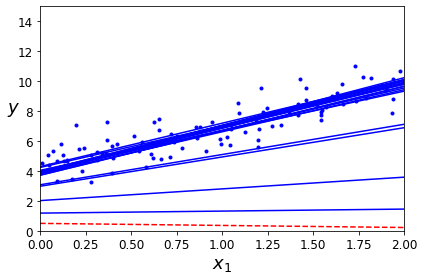

In [19]:
# While the Batch Gradient Descent code iterated 1,000 times through the whole training set, 
# this code goes through the training set only 50 times and reaches a fairly good solution

n_epochs = 50 # by convention we iterate by rounds of m iterations; each round is called an epoch
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                    # not shown in the book
            y_predict = X_new_b.dot(theta)           # not shown
            style = "b-" if i > 0 else "r--"         # not shown
            plt.plot(X_new, y_predict, style)        # not shown
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)                 # not shown

plt.plot(X, y, "b.")                                 # not shown
plt.xlabel("$x_1$", fontsize=18)                     # not shown
plt.ylabel("$y$", rotation=0, fontsize=18)           # not shown
plt.axis([0, 2, 0, 15])                              # not shown
save_fig("sgd_plot")                                 # not shown
plt.show()                                           # not shown

In [20]:
theta

array([[4.21076011],
       [2.74856079]])

> When using SGD, the training instances must be independent and identically distributed (IID) to ensure that the params get pulles toward the global minimum, on average.
A simple way to ensure this is to shuffle the instances during training. If you don't shuffle the instances - e.g., if the instances are srted by label - then SGD will start by optimizing for one label, then the next, and so on, and it will not settle close to the global minimum.

In [21]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, # the code will run for max 1000 epochs *
                       tol=1e-3, # * or until the loss drops by less than 0.001 during one epoch
                       penalty=None, # it doesn't use any regularization
                       eta0=0.1, # learning rate
                       random_state=42
                       )
sgd_reg.fit(X, y.ravel())

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.1, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty=None, power_t=0.25, random_state=42,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [22]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.24365286]), array([2.8250878]))

## 3) Mini-batch gradient descent

Mini-batch GD computes the gradients on small random sets of instances called mini-batches.

> The main advantage of Mini-batch GD over Stochastic GD is that you can get a **performance boost** from hardware optimization of matrix operations, especially when **using GPUs**.

In [0]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [24]:
theta

array([[4.25214635],
       [2.7896408 ]])

In [0]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

Saving figure gradient_descent_paths_plot


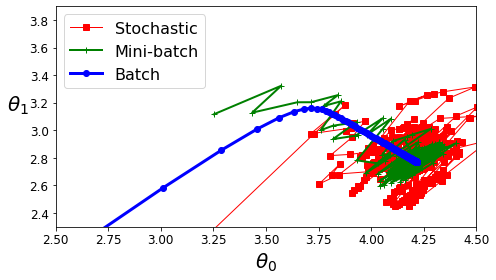

In [26]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
save_fig("gradient_descent_paths_plot")
plt.show()

# Polynomial regression

What if your data is actually more complex than a simple straight line? Surprisingly, you can actually use a linear model to fit nonlinear data. A simple way to do this is to add powers of each feature as new features, then train a linear model on this extended set of features. This technique is called **Polynomial Regression**.

In [0]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)

In [0]:
# generate some nonlinear data, based on a simple quadratic equation

m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

Saving figure quadratic_data_plot


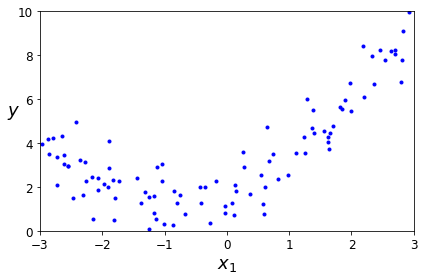

In [29]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_data_plot")
plt.show()

Clearly, a straight line will never fit this data properly

In [30]:
from sklearn.preprocessing import PolynomialFeatures

# add the square (2nd-degree polynomial) of the X feature in the training set as new feature
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [31]:
X_poly[0]

array([-0.75275929,  0.56664654])

X_poly now contains the original feature of X plus the square of this feature.

In [32]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
# fit a LinearRegression model to this extended training data
lin_reg.fit(X_poly, y)
print("bias term: %s" % lin_reg.intercept_)
print("weights: %s" % lin_reg.coef_)

bias term: [1.78134581]
weights: [[0.93366893 0.56456263]]


The model estimates $\hat{y} = {0.56}{x_1^2} + {0.93}{x_1} + {1.78}$ when in fact the original function was ${y} = {0.5}{x_1^2} + {1.0}{x_1} + {2.0} + {Gaussian \space noise}$

Saving figure quadratic_predictions_plot


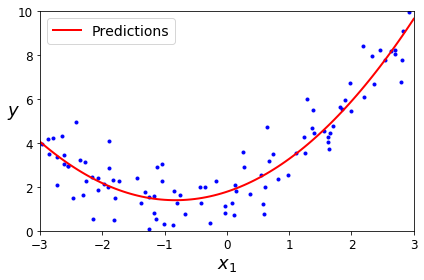

In [33]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_predictions_plot")
plt.show()

Note that when there are multiple features, **Polynomial Regression is capable of finding relationships between features** (which is something a plain Linear Regression model cannot do).

For example, if there were two features a and b, PolynomialFeatures with degree=3 would not only add the features $a^2$, $a^3$, $b^2$, and $b^3$, but also the combinations $ab$, $a^2b$, and $ab^2$.

> PolynomialFeatures(degree=d) transforms an array containing n features into an array containing $\frac{(n+d)!}{(d!n!)}$ features, where n! is the factorial of n, equal to 1 × 2 × 3 × ⋯ × n. Beware of the combinatorial explosion of the number of features!

# Learning Curves

Saving figure high_degree_polynomials_plot


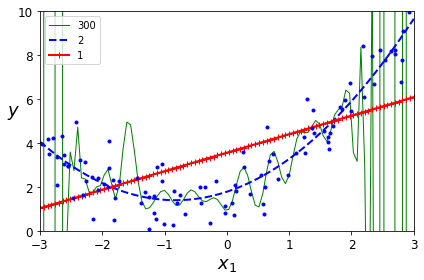

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("high_degree_polynomials_plot")
plt.show()

&uarr; applies a 300-degree polynomial model to the preceding training data, and compares the result with a pure linear model and a quadratic model (2nd-degree polynomial). Notice how the 300-degree polynomial model wiggles around to get as close as possible to the training instances.
* high-degree Polynomial Regression model is severely overfitting the training data
* the linear model is underfitting it
 

**How can you tell that your model is overfitting or underfitting the data?**

1) Use cross-validation to get an estimate of a model’s generalization performance. 
* If a model performs well on the training data but generalizes poorly according to the cross-validation metrics, then your model is overfitting. 
* If it performs poorly on both, then it is underfitting. This is one way to tell when a model is too simple or too complex.

2) Look at the learning curves: these are plots of the model’s performance on the training set and the validation set as a function of the training set size (or the training iteration). To generate the plots, simply train the model several times on different sized subsets of the training set.

In [0]:
# The following code defines a function that plots the learning curves of a model given some training data

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="training set")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="validation set")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown

Saving figure underfitting_learning_curves_plot


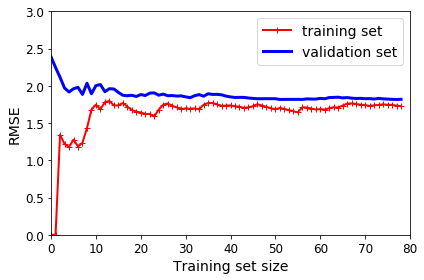

In [36]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                         # not shown in the book
save_fig("underfitting_learning_curves_plot")   # not shown
plt.show()                                      # not shown

&uarr; First, let’s look at the performance on the training data: when there are just one or two instances in the training set, the model can fit them perfectly, which is why the curve starts at zero. But as new instances are added to the training set, it becomes impossible for the model to fit the training data perfectly, both because the data is noisy and because it is not linear at all. So the error on the training data goes up until it reaches a plateau, at which point adding new instances to the training set doesn’t make the average error much better or worse. Now let’s look at the performance of the model on the validation data. When the model is trained on very few training instances, it is incapable of generalizing properly, which is why the validation error is initially quite big. Then as the model is shown more training examples, it learns and thus the validation error slowly goes down. However, once again a straight line cannot do a good job modeling the data, so the error ends up at a plateau, very close to the other curve.
These learning curves are typical of an underfitting model. Both curves have reached a plateau; they are close and fairly high.


> If your model is underfitting the training data, adding more training examples will not help. You need to use a more complex model or come up with better features.

Saving figure learning_curves_plot


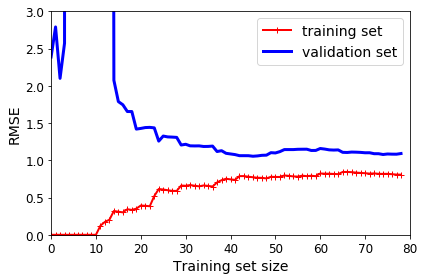

In [37]:
# learning curves of a 10th-degree polynomial model on the same data
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])           # not shown
save_fig("learning_curves_plot")  # not shown
plt.show()                        # not shown

&uarr; These learning curves look a bit like the previous ones, but there are two very important differences:
The error on the training data is much lower than with the Linear Regression model.
There is a gap between the curves. This means that the model performs significantly better on the training data than on the validation data, which is the hallmark of an overfitting model. However, if you used a much larger training set, the two curves would continue to get closer.


> One way to improve an overfitting model is to feed it more training data until the validation error reaches the training error.

An important theoretical result of statistics and Machine Learning is the fact that a **model’s generalization error can be expressed as the sum of three very different errors**:

1) Bias

This part of the generalization error is due to wrong assumptions, such as assuming that the data is linear when it is actually quadratic. A high-bias model is most likely to underfit the training data.

2) Variance

This part is due to the model’s excessive sensitivity to small variations in the training data. A model with many degrees of freedom (such as a high-degree polynomial model) is likely to have high variance, and thus to overfit the training data.

3) Irreducible error

This part is due to the noisiness of the data itself. The only way to reduce this part of the error is to clean up the data (e.g., fix the data sources, such as broken sensors, or detect and remove outliers).

> Increasing a model’s complexity will typically increase its variance and reduce its bias. Conversely, reducing a model’s complexity increases its bias and reduces its variance. This is why it is called a tradeoff.


# Regularized models

> A good way to **reduce overfitting** is to **regularize the model** (i.e., to constrain it): the fewer degrees of freedom it has, the harder it will be for it to overfit the data. For example, a simple way to regularize a polynomial model is to reduce the number of polynomial degrees.

> For a **linear model**, **regularization** is typically achieved by **constraining the weights of the model**.

Three different ways to constrain the weights:
* Ridge Regression
* Lasso Regression
* Elastic Net

In [0]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

## Ridge Regression (Tikhonov regularization)

Is a regularized version of Linear Regression.

A regularization term equal to $\alpha\sum_{i=1}^n{\theta_i^2}$ is added to the cost function - this forces the learning algorithm to not only fit the data but also **keep the model weights as small as possible**.

The hyperparameter α controls how much you want to regularize the model. If α = 0 then Ridge Regression is just Linear Regression. If α is very large, then all weights end up very close to zero and the result is a flat line going through the data’s mean.

> The regularization term should only be added to the cost function during training

> Once the model is trained, you want to evaluate the model’s performance using the unregularized performance measure.
>> &uarr; $?$

Ridge Regression cost function:

${J(\theta)} = {MSE(\theta)} + {\alpha}\frac{1}{2}\sum_{i=1}^n{\theta_i^2}$

> Note that the bias term $θ_0$ is not regularized (the sum starts at i = 1, not 0).

> *J(θ) is a common notation for cost functions that don't have a short name*

>  If we define **w** as the vector of feature weights ($θ_1$ to $θ_n$), then the regularization term is simply equal to ½(∥ w ∥$_2$)$^2$, where ∥ w ∥$_2$ represents the ℓ$_2$ norm of the weight vector. For Gradient Descent, just add αw to the MSE gradient vector.

> It is quite common for the cost function used during training to be different from the performance measure used for testing. Apart from regularization, another reason why they might be different is that **a good training cost function should have optimization-friendly derivatives, while the performance measure used for testing should be as close as possible to the final objective**. A good example of this is a classifier trained using a cost function such as the log loss (discussed in a moment) but evaluated using precision/recall.

Ridge Regression closed-form solution (Eq 4-9):

$\hat{\theta} = {(X^TX+\alpha A)}^{-1} {X^T} {y}$, where
* A is the (n + 1) × (n + 1) identity matrix except with a 0 in the top-left cell, corresponding to the bias term

In [39]:
# perform Ridge Regression with Scikit-Learn using a closed-form solution (Eq 4-9)

from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [40]:
# perform Ridge Regression with Scikit-Learn using a Stochastic Average Gradient descent

ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.5507201]])

Saving figure ridge_regression_plot


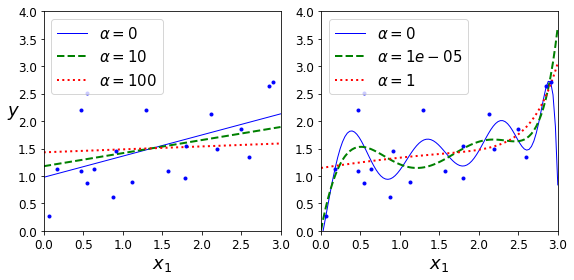

In [41]:
from sklearn.linear_model import Ridge

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

save_fig("ridge_regression_plot")
plt.show()

On the **left**, plain Ridge models are used, leading to linear predictions -- **linear model**

On the **right**, the data is first expanded using PolynomialFeatures(degree=10), then it is scaled using a StandardScaler, and finally the Ridge models are applied to the resulting features: this is *Polynomial Regression with Ridge regularization* -- **polynomial model**

>> $?/$ what's with the StandardScaler?

**Note**: to be future-proof, we set `max_iter=1000` and `tol=1e-3` because these will be the default values in Scikit-Learn 0.21.

In [42]:
# perform Ridge Regression with Scikit-Learn using Stochastic Gradient Descent

sgd_reg = SGDRegressor(penalty="l2", max_iter=1000, tol=1e-3, random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.47012588])

## Lasso Regression

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.802867703827423, tolerance: 0.0009294783355207351
  positive)


Saving figure lasso_regression_plot


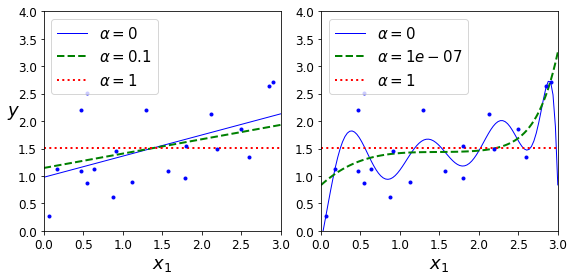

In [43]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)

save_fig("lasso_regression_plot")
plt.show()

In [44]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

## Elastic Net


In [45]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

In [0]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

Early stopping example:

In [0]:
from sklearn.base import clone

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

Create the graph:

Saving figure early_stopping_plot


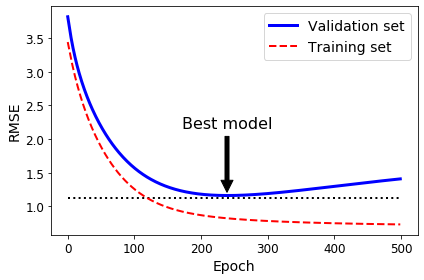

In [48]:
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
save_fig("early_stopping_plot")
plt.show()

In [49]:
best_epoch, best_model

(239,
 SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
              eta0=0.0005, fit_intercept=True, l1_ratio=0.15,
              learning_rate='constant', loss='squared_loss', max_iter=1,
              n_iter_no_change=5, penalty=None, power_t=0.25, random_state=42,
              shuffle=True, tol=-inf, validation_fraction=0.1, verbose=0,
              warm_start=True))

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [0]:
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

Saving figure lasso_vs_ridge_plot


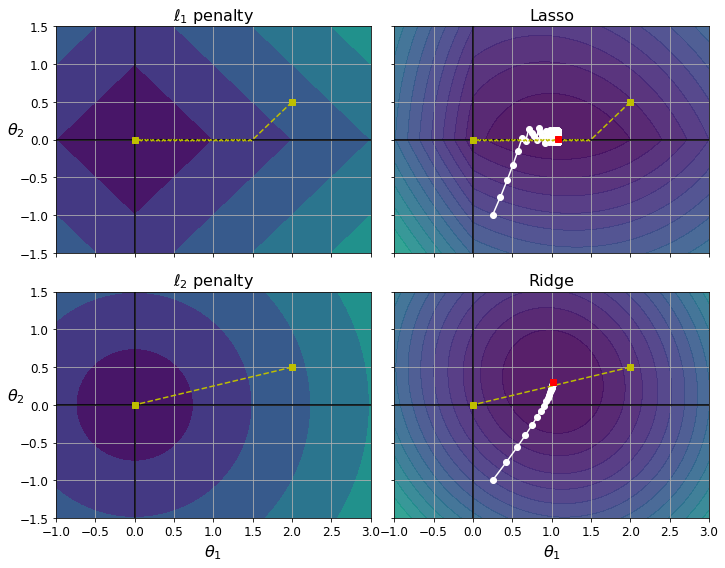

In [52]:
def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.05, n_iterations = 200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + l2 * theta
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.1, 8))
for i, N, l1, l2, title in ((0, N1, 2., 0, "Lasso"), (1, N2, 0,  2., "Ridge")):
    JR = J + l1 * N1 + l2 * 0.5 * N2**2
    
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levelsJ=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    levelsN=np.linspace(0, np.max(N), 10)
    
    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(np.array([[2.0], [0.5]]), Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)

    ax = axes[i, 0]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, N / 2., levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.set_title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)
    ax.set_ylabel(r"$\theta_2$", fontsize=16, rotation=0)

    ax = axes[i, 1]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.plot(t1r_min, t2r_min, "rs")
    ax.set_title(title, fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)

save_fig("lasso_vs_ridge_plot")
plt.show()

# Logistic regression

Saving figure logistic_function_plot


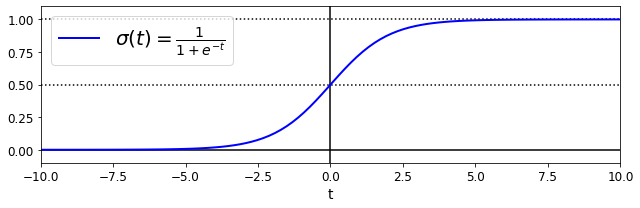

In [53]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
save_fig("logistic_function_plot")
plt.show()

In [54]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']

In [55]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [0]:
X = iris["data"][:, 3:]  # petal width
y = (iris["target"] == 2).astype(np.int)  # 1 if Iris virginica, else 0

**Note**: To be future-proof we set `solver="lbfgs"` since this will be the default value in Scikit-Learn 0.22.

In [57]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

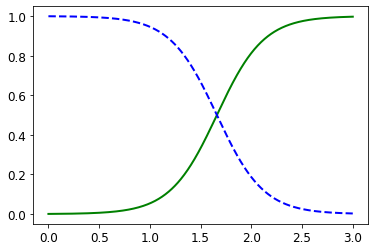

In [58]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")

The figure in the book actually is actually a bit fancier:

Saving figure logistic_regression_plot


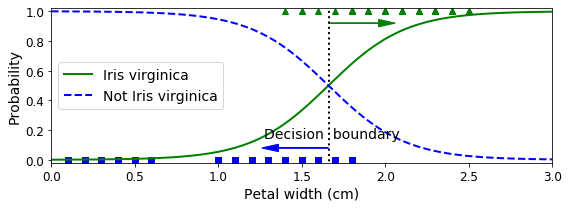

In [59]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
save_fig("logistic_regression_plot")
plt.show()

In [60]:
decision_boundary

array([1.66066066])

In [61]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

Saving figure logistic_regression_contour_plot


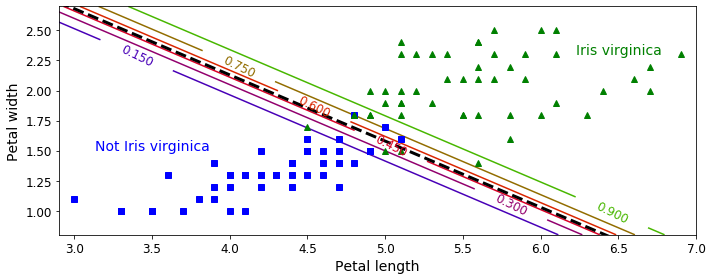

In [62]:
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
save_fig("logistic_regression_contour_plot")
plt.show()

In [63]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Saving figure softmax_regression_contour_plot


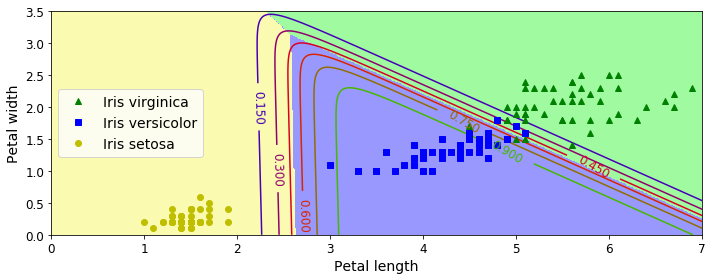

In [64]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
save_fig("softmax_regression_contour_plot")
plt.show()

In [65]:
softmax_reg.predict([[5, 2]])

array([2])

In [66]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

# Exercise solutions

## 1. to 11.

See appendix A.

## 12. Batch Gradient Descent with early stopping for Softmax Regression
(without using Scikit-Learn)

Let's start by loading the data. We will just reuse the Iris dataset we loaded earlier.

In [0]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

We need to add the bias term for every instance ($x_0 = 1$):

In [0]:
X_with_bias = np.c_[np.ones([len(X), 1]), X]

And let's set the random seed so the output of this exercise solution is reproducible:

In [0]:
np.random.seed(2042)

The easiest option to split the dataset into a training set, a validation set and a test set would be to use Scikit-Learn's `train_test_split()` function, but the point of this exercise is to try understand the algorithms by implementing them manually. So here is one possible implementation:

In [0]:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

rnd_indices = np.random.permutation(total_size)

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

The targets are currently class indices (0, 1 or 2), but we need target class probabilities to train the Softmax Regression model. Each instance will have target class probabilities equal to 0.0 for all classes except for the target class which will have a probability of 1.0 (in other words, the vector of class probabilities for ay given instance is a one-hot vector). Let's write a small function to convert the vector of class indices into a matrix containing a one-hot vector for each instance:

In [0]:
def to_one_hot(y):
    n_classes = y.max() + 1
    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))
    Y_one_hot[np.arange(m), y] = 1
    return Y_one_hot

Let's test this function on the first 10 instances:

In [72]:
y_train[:10]

array([0, 1, 2, 1, 1, 0, 1, 1, 1, 0])

In [73]:
to_one_hot(y_train[:10])

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

Looks good, so let's create the target class probabilities matrix for the training set and the test set:

In [0]:
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

Now let's implement the Softmax function. Recall that it is defined by the following equation:

$\sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}$

In [0]:
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums

We are almost ready to start training. Let's define the number of inputs and outputs:

In [0]:
n_inputs = X_train.shape[1] # == 3 (2 features plus the bias term)
n_outputs = len(np.unique(y_train))   # == 3 (3 iris classes)

Now here comes the hardest part: training! Theoretically, it's simple: it's just a matter of translating the math equations into Python code. But in practice, it can be quite tricky: in particular, it's easy to mix up the order of the terms, or the indices. You can even end up with code that looks like it's working but is actually not computing exactly the right thing. When unsure, you should write down the shape of each term in the equation and make sure the corresponding terms in your code match closely. It can also help to evaluate each term independently and print them out. The good news it that you won't have to do this everyday, since all this is well implemented by Scikit-Learn, but it will help you understand what's going on under the hood.

So the equations we will need are the cost function:

$J(\mathbf{\Theta}) =
- \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}$

And the equation for the gradients:

$\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}$

Note that $\log\left(\hat{p}_k^{(i)}\right)$ may not be computable if $\hat{p}_k^{(i)} = 0$. So we will add a tiny value $\epsilon$ to $\log\left(\hat{p}_k^{(i)}\right)$ to avoid getting `nan` values.

In [77]:
eta = 0.01
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    error = Y_proba - Y_train_one_hot
    if iteration % 500 == 0:
        print(iteration, loss)
    gradients = 1/m * X_train.T.dot(error)
    Theta = Theta - eta * gradients

0 5.446205811872683
500 0.8350062641405651
1000 0.6878801447192402
1500 0.6012379137693314
2000 0.5444496861981872
2500 0.5038530181431525
3000 0.47292289721922487
3500 0.44824244188957774
4000 0.42786510939287936
4500 0.41060071429187134
5000 0.3956780375390374


And that's it! The Softmax model is trained. Let's look at the model parameters:

In [78]:
Theta

array([[ 3.32094157, -0.6501102 , -2.99979416],
       [-1.1718465 ,  0.11706172,  0.10507543],
       [-0.70224261, -0.09527802,  1.4786383 ]])

Let's make predictions for the validation set and check the accuracy score:

In [79]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.9666666666666667

Well, this model looks pretty good. For the sake of the exercise, let's add a bit of $\ell_2$ regularization. The following training code is similar to the one above, but the loss now has an additional $\ell_2$ penalty, and the gradients have the proper additional term (note that we don't regularize the first element of `Theta` since this corresponds to the bias term). Also, let's try increasing the learning rate `eta`.

In [80]:
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    error = Y_proba - Y_train_one_hot
    if iteration % 500 == 0:
        print(iteration, loss)
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

0 6.629842469083912
500 0.5339667976629505
1000 0.5036400750148942
1500 0.49468910594603216
2000 0.4912968418075476
2500 0.48989924700933296
3000 0.4892990598451198
3500 0.48903512443978603
4000 0.4889173621830818
4500 0.48886433374493027
5000 0.48884031207388184


Because of the additional $\ell_2$ penalty, the loss seems greater than earlier, but perhaps this model will perform better? Let's find out:

In [81]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

Cool, perfect accuracy! We probably just got lucky with this validation set, but still, it's pleasant.

Now let's add early stopping. For this we just need to measure the loss on the validation set at every iteration and stop when the error starts growing.

In [82]:
eta = 0.1 
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter
best_loss = np.infty

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

    logits = X_valid.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_valid_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    if iteration % 500 == 0:
        print(iteration, loss)
    if loss < best_loss:
        best_loss = loss
    else:
        print(iteration - 1, best_loss)
        print(iteration, loss, "early stopping!")
        break

0 4.7096017363419875
500 0.5739711987633519
1000 0.5435638529109128
1500 0.5355752782580261
2000 0.5331959249285545
2500 0.5325946767399383
2765 0.5325460966791898
2766 0.5325460971327978 early stopping!


In [83]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

Still perfect, but faster.

Now let's plot the model's predictions on the whole dataset:

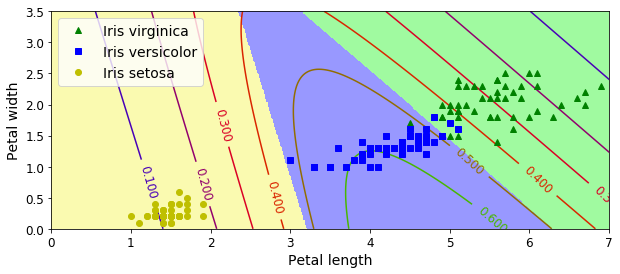

In [84]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]

logits = X_new_with_bias.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

And now let's measure the final model's accuracy on the test set:

In [85]:
logits = X_test.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_test)
accuracy_score

0.9333333333333333

Our perfect model turns out to have slight imperfections. This variability is likely due to the very small size of the dataset: depending on how you sample the training set, validation set and the test set, you can get quite different results. Try changing the random seed and running the code again a few times, you will see that the results will vary.